In [67]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='browser'
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import scipy as sp
import scipy.cluster

In [2]:
density_data = pd.read_csv("../Curated_data/cluster_0_data.csv", low_memory=False)


In [3]:
mineral = 'Density_gcm3'
filter = ['Sulph1_Code', 'Sulph1_Pct', 'Sulph2_Code', 'Sulph2_Pct']
deposit_data = density_data

deposit_data = deposit_data.dropna(subset=[mineral] + filter)
df1 = deposit_data
variable = mineral

In [4]:
two_composite_1covariates = deposit_data

# Calculate the percentage of missing values for each variable
missing_percentage = (two_composite_1covariates.isnull().sum() / len(two_composite_1covariates)) * 100

# Identify variables with more than 15% missing values
variables_to_remove = missing_percentage[missing_percentage > 5].index

# Drop the identified variables from the DataFrame
two_composite_1covariates = two_composite_1covariates.drop(columns=variables_to_remove)


encoded_data = two_composite_1covariates.copy()

threshold = 10

for column in two_composite_1covariates.columns:
    if two_composite_1covariates[column].dtype == 'object':
        unique_values = two_composite_1covariates[column].nunique()
        
        # Check if the number of unique values is within the threshold
        if unique_values <= threshold:
            # Perform one-hot encoding for columns with unique values within the threshold
            encoded_columns = pd.get_dummies(encoded_data[column], prefix=column)
            encoded_columns = encoded_columns.astype(int)  # Convert to integers (0 or 1)
            encoded_data = pd.concat([encoded_data, encoded_columns], axis=1)
            encoded_data = encoded_data.drop(columns=[column])




# Identify the encoded columns based on the common pattern
encoded_columns = [col for col in encoded_data.columns if '_Code_' in col]

# List to store the total columns
total_columns = []

# Iterate through the encoded columns and calculate the total for each category
for col in encoded_columns:
    # Extract the prefix and original column name
    prefix, original_column = col.split('_Code_')
    
    # Calculate the total for the category
    total_column = f"{original_column}_Total"
    total_columns.append(total_column)
    
    # Multiply the code column by the corresponding percentage column and sum them
    encoded_data[total_column] = (
        encoded_data[f"{prefix}_Code_{original_column}"] * encoded_data[f"{prefix}_Pct"]
    )

# List to store the total columns
total_columns = []

# Initialize a dictionary to accumulate totals for each category
category_totals = {}

# Iterate through the encoded columns and calculate the total for each category
for col in encoded_columns:
    # Extract the prefix and original column name
    prefix, original_column = col.split('_Code_')
    
    # Calculate the total for the category
    total_column = f"{original_column}_Total"
    if total_column not in total_columns:
        total_columns.append(total_column)
    
    # Multiply the code column by the corresponding percentage column
    total_values = encoded_data[f"{prefix}_Code_{original_column}"] * encoded_data[f"{prefix}_Pct"]
    
    # Accumulate the totals for each category
    if total_column in category_totals:
        category_totals[total_column] += total_values
    else:
        category_totals[total_column] = total_values

# Add accumulated totals to the DataFrame
for total_column, total_values in category_totals.items():
    encoded_data[total_column] = total_values


In [5]:
variable_names = ['Sc_ppm',
 'Al_pct',
 'Y_ppm',
 'V_ppm',
 'Sr_ppm',
 'Ca_pct',
 'P_ppm',
 'Si_pct',
 'Li_ppm',
 'Mg_pct',
 'La_ppm',
 'RQD_Pct',
 'Alt1_Int_wk',
 'Ba_ppm',
 'Sulph1_Code_PO',
 'IP_pct',
 'Sulph2_Code_CP',
 'Sulph2_Code_PO',
 'X',
 'PY_Total',
 'Z',
 'PO_Total',
 'CP_Total',
 'Cr_ppm',
 'B_ppm',
 'Y',
 'Sb_ppm',
 'Weathering']

In [6]:
filtered_encoded_data = encoded_data[encoded_data.columns.intersection(variable_names+ ['Density_gcm3', 'Name'])]

deposit_data = encoded_data[['Name', 'X', 'Y', 'Z', 'Density_gcm3', 'RQD_Pct', 'Cr_ppm', 'CP_Total',
       'PO_Total', 'PY_Total']]
total_columns = ['CP_Total','PO_Total', 'PY_Total']
#covariates = total_columns[:3] + ['RQD_Pct', 'Cr_ppm']
#covariates = total_columns[:3] 
covariates = []

deposit_data.describe()
deposit_data.fillna(0, inplace=True)
deposit_data

C:\Users\23478671\AppData\Local\Temp\ipykernel_1424\1885046316.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Name,X,Y,Z,Density_gcm3,RQD_Pct,Cr_ppm,CP_Total,PO_Total,PY_Total
393,KV-NME001,3498922.13,7511747.51,148.80,3.13,88.00,212.6,1.0,1.0,0.0
394,KV-NME001,3498922.68,7511747.45,146.88,3.15,88.00,268.0,1.0,1.0,0.0
434,KV-NME001,3498945.16,7511745.25,70.14,3.22,99.00,215.0,1.0,1.0,0.0
435,KV-NME001,3498945.73,7511745.20,68.22,3.22,99.00,236.0,1.5,2.0,0.0
436,KV-NME001,3498946.29,7511745.15,66.30,3.22,99.00,256.0,2.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...
81071,KV365,3499347.52,7510618.17,85.03,3.44,92.35,131.0,0.2,3.0,0.0
81072,KV365,3499347.32,7510617.19,83.30,3.43,92.35,125.0,0.2,3.0,0.0
81073,KV365,3499347.13,7510616.22,81.56,3.44,85.84,128.0,0.2,3.0,0.0
81074,KV365,3499346.93,7510615.24,79.83,3.40,85.84,129.0,0.2,3.0,0.0


In [7]:
# Define the columns to normalize
columns_to_normalize = ['X', 'Y', 'Z']   # Add all columns you want to normalize

min_values = deposit_data[columns_to_normalize].min()

for column in columns_to_normalize:
    deposit_data[column] = deposit_data[column] - min_values[column]

# Calculate the minimum and maximum values from the entire dataset
min_values = deposit_data[columns_to_normalize].min().min()
max_values = deposit_data[columns_to_normalize].max().max()

# Scale the data to (0, 1) using the calculated minimum and maximum values
for column in columns_to_normalize:
    deposit_data[column] = (deposit_data[column] - min_values) / (max_values - min_values)

scaler = MinMaxScaler()
deposit_data.loc[:, [mineral] +covariates] = scaler.fit_transform(deposit_data.loc[:,[mineral] + covariates])


C:\Users\23478671\AppData\Local\Temp\ipykernel_1424\1488387108.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\23478671\AppData\Local\Temp\ipykernel_1424\1488387108.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\23478671\AppData\Local\Temp\ipykernel_1424\1488387108.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [8]:
deposit_data

,Name,X,Y,Z,Density_gcm3,RQD_Pct,Cr_ppm,CP_Total,PO_Total,PY_Total
393,KV-NME001,0.437814,0.509816,0.461455,0.400922,88.00,212.6,1.0,1.0,0.0
394,KV-NME001,0.438061,0.509789,0.460591,0.410138,88.00,268.0,1.0,1.0,0.0
434,KV-NME001,0.448174,0.508800,0.426068,0.442396,99.00,215.0,1.0,1.0,0.0
435,KV-NME001,0.448431,0.508777,0.425204,0.442396,99.00,236.0,1.5,2.0,0.0
436,KV-NME001,0.448683,0.508755,0.424340,0.442396,99.00,256.0,2.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...
81071,KV365,0.629186,0.001755,0.432766,0.543779,92.35,131.0,0.2,3.0,0.0
81072,KV365,0.629096,0.001314,0.431988,0.539171,92.35,125.0,0.2,3.0,0.0
81073,KV365,0.629011,0.000877,0.431205,0.543779,85.84,128.0,0.2,3.0,0.0
81074,KV365,0.628921,0.000436,0.430427,0.525346,85.84,129.0,0.2,3.0,0.0


In [9]:
lon = df1.values[:,4]
lat = df1.values[:,5]
az = df1.values[:,6]

normalized_lon = (lon-min(lon))/(max(lon)-min(lon))
normalized_lat = (lat-min(lat))/(max(lat)-min(lat))
normalized_az = (az-min(az))/(max(az)-min(az))
N = lon.shape[0]

In [10]:
# Assuming deposit_data is your DataFrame
# Extract the names of the first 98 columns
phi_columns = deposit_data.columns[1:4].tolist()

# Display the list of column names
print(phi_columns)


['X', 'Y', 'Z']


C:\Users\23478671\AppData\Local\Temp\ipykernel_1424\146396046.py:27: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



- Iteration 0, MSE: 0.5571


C:\Users\23478671\AppData\Local\Temp\ipykernel_1424\146396046.py:28: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\23478671\AppData\Local\Temp\ipykernel_1424\146396046.py:29: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\23478671\AppData\Local\Temp\ipykernel_1424\146396046.py:30: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



- Iteration 100, MSE: 0.0219
- Iteration 200, MSE: 0.0170
- Iteration 300, MSE: 0.0153
- Iteration 400, MSE: 0.0151
- Iteration 500, MSE: 0.0141
- Iteration 600, MSE: 0.0131


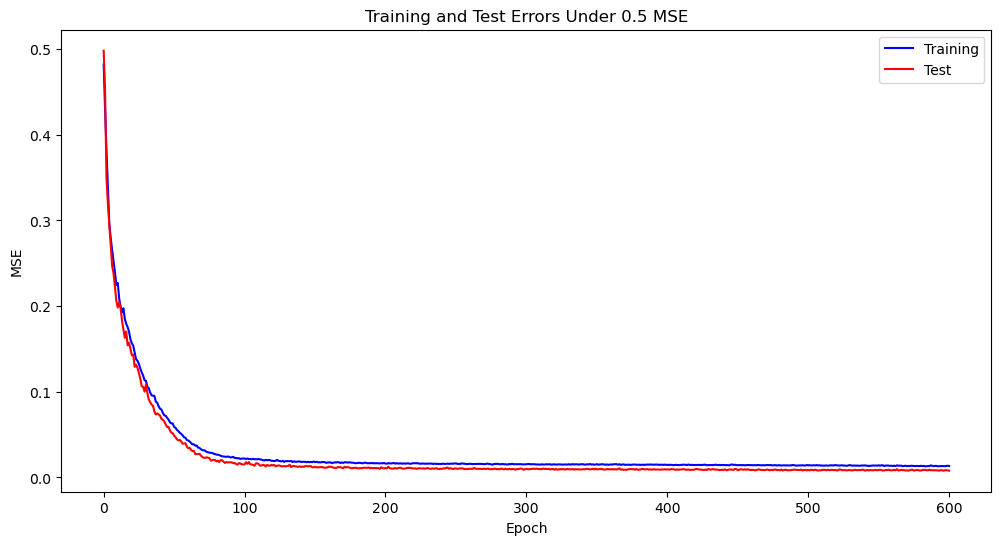

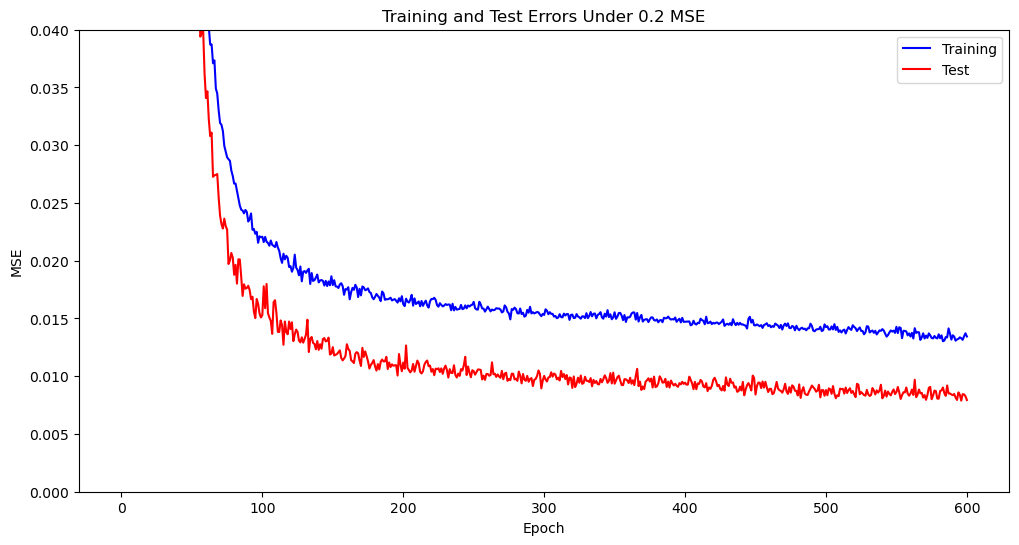

In [11]:
p = len(phi_columns) + len(covariates)

x = deposit_data[phi_columns + covariates].values #[:,np.newaxis] makes the second dimension explicit
y = deposit_data[[variable]].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
x = x.reshape(len(deposit_data),p)
x = x[:,[i for i in range(p)]]

x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)


# Determine the size of the test set (e.g., 20% of the data)
test_size = int(0.2 * len(x))

# Generate random indices for the test set
test_indices = np.random.choice(len(x), size=test_size, replace=False)

# Create train and test sets based on the indices
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]

x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# model = nn.Sequential(
#     nn.Linear(in_features=p, out_features=1000),
#     nn.ReLU(),
#     nn.Linear(in_features=1000, out_features=1)
# )

model = nn.Sequential(
    nn.Linear(in_features=p, out_features=100),
    nn.ReLU(),
    nn.Dropout(0.5) ,
    nn.BatchNorm1d(100),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=100, out_features=100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(in_features=100, out_features=1))


mse_loss = nn.MSELoss()
#Apparently lr=0.005 is better than 0.01 and than 0.001: quicker and better convergence
#optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []  # To store training losses during training
test_losses = []   # To store test losses during training

for step in range(601):
    pre = model(x_train)
    mse = mse_loss(pre, y_train)
    cost = mse

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    pre_train = model(x_train)
    mse_train = mse_loss(pre_train, y_train)
    train_losses.append(mse_train.item())

    # Evaluate the model on the test set
    pre_test = model(x_test)
    mse_test = mse_loss(pre_test, y_test)
    test_losses.append(mse_test.item())

    if step % 100 == 0:
        print(f'- Iteration {step}, MSE: {mse.item():.4f}')




# Create a plot showing only values under 0.2 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
#plt.ylim(0, 0.5)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.5 MSE')
plt.show()



# Create a plot showing only values under 0.2 on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training', color='blue')
plt.plot(test_losses, label='Test', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.04)  # Set the y-axis limit to filter values under 0.05
plt.legend()
plt.title('Training and Test Errors Under 0.2 MSE')
plt.show()








In [12]:
# Function to print evaluation metrics
def print_metrics(actual, predicted, set_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    print(f"Metrics for {set_name} set:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R^2: {r2:.4f}\n")

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

torch.manual_seed(42)
np.random.seed(42)

# Assuming deposit_data, covariates, and other necessary variables are defined

# Create an array to store metrics for each fold
test_mse_list = []
test_rmse_list = []
test_mae_list = []
test_r2_list = []



# Define the number of folds for cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(deposit_data)):
    train_data, test_data = deposit_data.iloc[train_index], deposit_data.iloc[test_index]

    x_train = train_data[phi_columns + covariates].values
    y_train = train_data['Density_gcm3'].values

    x_test = test_data[phi_columns + covariates].values
    y_test = test_data['Density_gcm3'].values

    # Define your neural network
    model = nn.Sequential(
        nn.Linear(in_features=p, out_features=100),
        nn.ReLU(),
        nn.Dropout(0.5) ,
        nn.BatchNorm1d(100),
        nn.Linear(in_features=100, out_features=100),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(in_features=100, out_features=100),
        nn.ReLU(),
        nn.BatchNorm1d(100),
        nn.Linear(in_features=100, out_features=1))


    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []  # To store training losses during training
    test_losses = []   # To store test losses during training

    # Training loop
    for step in range(601):
        pre = model(torch.tensor(x_train, dtype=torch.float32))
        mse = mse_loss(pre, torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32))
        cost = mse

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        pre_test = model(torch.tensor(x_test, dtype=torch.float32))
        mse_test = mse_loss(pre_test, torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32))
        test_losses.append(mse_test.item())

    # Store metrics for this fold
    test_predictions_fold = model(torch.tensor(x_test, dtype=torch.float32)).detach().numpy().flatten()
    test_mse_list.append(mean_squared_error(y_test, test_predictions_fold))
    test_mae_list.append(mean_absolute_error(y_test, test_predictions_fold))
    test_r2_list.append(r2_score(y_test, test_predictions_fold))

    # Print metrics for the current fold
    print(f"\nMetrics for Fold {fold + 1}:")
    print_metrics(y_test, test_predictions_fold, "Test")

# Print average metrics across folds
print("\nAverage Metrics Across Folds:")
print(f"  Average MSE: {np.mean(test_mse_list):.4f}")
print(f"  Average MAE: {np.mean(test_mae_list):.4f}")
print(f"  Average R2: {np.mean(test_r2_list):.4f}")
print(f"  STD MSE: {np.std(test_mse_list):.4f}")
print(f"  STD MAE: {np.std(test_mae_list):.4f}")
print(f"  STD R2: {np.std(test_r2_list):.4f}")



Metrics for Fold 1:
Metrics for Test set:
  MSE: 0.0115
  RMSE: 0.1074
  MAE: 0.0742
  R^2: 0.2766


Metrics for Fold 2:
Metrics for Test set:
  MSE: 0.0124
  RMSE: 0.1112
  MAE: 0.0654
  R^2: 0.0563


Metrics for Fold 3:
Metrics for Test set:
  MSE: 0.0093
  RMSE: 0.0964
  MAE: 0.0644
  R^2: 0.3693


Metrics for Fold 4:
Metrics for Test set:
  MSE: 0.0092
  RMSE: 0.0960
  MAE: 0.0671
  R^2: 0.3168


Metrics for Fold 5:
Metrics for Test set:
  MSE: 0.0114
  RMSE: 0.1069
  MAE: 0.0721
  R^2: 0.3651


Metrics for Fold 6:
Metrics for Test set:
  MSE: 0.0093
  RMSE: 0.0962
  MAE: 0.0709
  R^2: 0.2725


Metrics for Fold 7:
Metrics for Test set:
  MSE: 0.0146
  RMSE: 0.1210
  MAE: 0.0780
  R^2: 0.1885


Metrics for Fold 8:
Metrics for Test set:
  MSE: 0.0172
  RMSE: 0.1311
  MAE: 0.0838
  R^2: 0.0457


Metrics for Fold 9:
Metrics for Test set:
  MSE: 0.0104
  RMSE: 0.1020
  MAE: 0.0718
  R^2: 0.1786


Metrics for Fold 10:
Metrics for Test set:
  MSE: 0.0129
  RMSE: 0.1136
  MAE: 0.0752
  R^

In [33]:
x_test[:,0]

array([0.43806122, 0.45350093, 0.45852603, 0.3276889 , 0.42907272,
       0.42997247, 0.43147505, 0.43746738, 0.43984272, 0.44489032,
       0.44904716, 0.44934408, 0.45670854, 0.46279534, 0.46508521,
       0.46593997, 0.46622789, 0.46651131, 0.46765399, 0.47776718,
       0.48085782, 0.48317018, 0.49175379, 0.49719278, 0.49987853,
       0.50125065, 0.51109841, 0.51126487, 0.52477011, 0.52496356,
       0.52593529, 0.52652013, 0.52710946, 0.53113135, 0.53831585,
       0.54162243, 0.5424502 , 0.55470029, 0.46722211, 0.47187832,
       0.47255763, 0.4741187 , 0.48163161, 0.48855068, 0.48868565,
       0.49161433, 0.49324738, 0.4942506 , 0.49609059, 0.49657195,
       0.49813302, 0.49825449, 0.49897429, 0.49921272, 0.50053535,
       0.40692987, 0.41139713, 0.41466322, 0.42293192, 0.42439852,
       0.43722895, 0.44031059, 0.44088193, 0.44145777, 0.44260046,
       0.44336524, 0.4456731 , 0.44646488, 0.44825089, 0.45042828,
       0.45607421, 0.46074391, 0.46196307, 0.46257041, 0.46399

In [47]:
X, y = shap.datasets.california()


In [48]:
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [45]:
import shap

# build a Permutation explainer and explain the model predictions on the given dataset
explainer = shap.explainers.Permutation(model, x_train[:,0])
shap_values = explainer(torch.tensor(x_test, dtype=torch.float32))

# get just the explanations for the positive class
shap_values = shap_values[..., 1]

IndexError: tuple index out of range

In [13]:
import torch
import numpy as np

# Assuming `model` is your trained neural network
model.eval()

# Initialize an array to accumulate gradients for each feature
total_gradients = np.zeros_like(x_train[0], dtype=float)

# Iterate over all instances to accumulate gradients
for instance_index in range(len(x_train)):
    selected_instance = torch.tensor(x_train[instance_index], dtype=torch.float32).unsqueeze(0)  # Add a batch dimension
    selected_instance.requires_grad_(True)
    
    # Forward pass
    output = model(selected_instance)

    # Backward pass to compute gradients
    model.zero_grad()
    output.backward()

    # Accumulate gradients for each feature
    total_gradients += selected_instance.grad.detach().numpy()[0]

# Calculate feature importance as the absolute mean of gradients across instances
average_importance = np.abs(total_gradients / len(x_train))

# Print or use the average_importance as needed
print("Average Feature Importance:", average_importance)


Average Feature Importance: [0.1692288  0.04583756 0.10959013]
